## Generate dynamics dataset

In [11]:
!python ../src/generate_data.py ../data/train
!python ../src/generate_data.py -n 500 --random_seed 10 ../data/test

Failed to build trajectory for index 109, retrying
Failed to build trajectory for index 238, retrying
Failed to build trajectory for index 2135, retrying
Failed to build trajectory for index 3359, retrying
Failed to build trajectory for index 3712, retrying
Failed to build trajectory for index 4344, retrying
Failed to build trajectory for index 4876, retrying
Failed to build trajectory for index 8027, retrying
Failed to build trajectory for index 8060, retrying
Failed to build trajectory for index 8079, retrying
Failed to build trajectory for index 8194, retrying
Failed to build trajectory for index 9692, retrying
Failed to build trajectory for index 9915, retrying
Failed to build trajectory for index 9944, retrying


## dev

In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2

os.chdir("../src/")

from environment import Environment
from random_env import get_random_env

In [ ]:
scale = 4
env, _, _ = get_random_env(scale)

[(6, -2), (4, 0), (6, 4), (5, 4), (6, 5), (5, 3), (3, 1), (2, 2), (2, 1), (1, 0)]


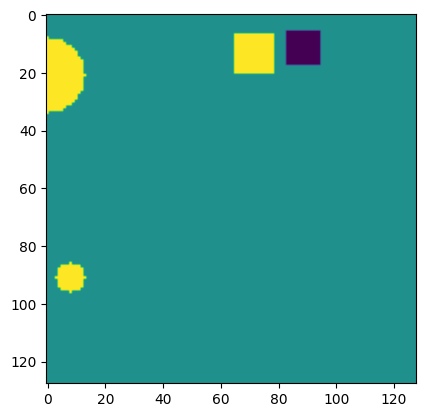

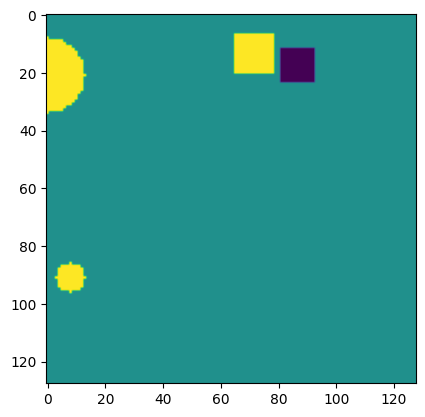

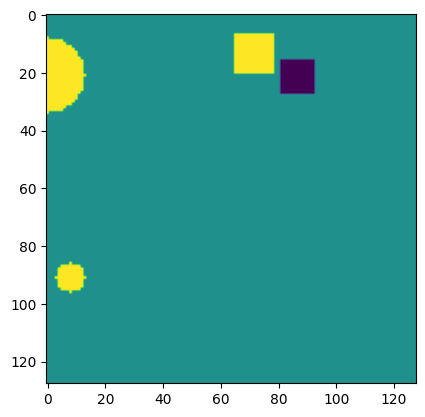

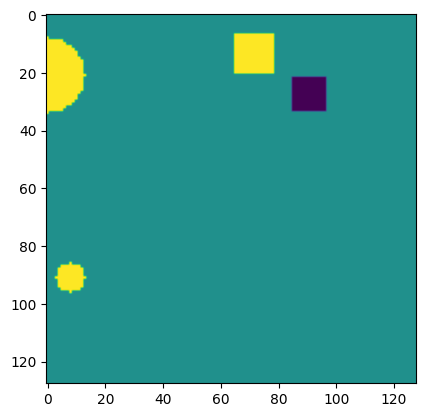

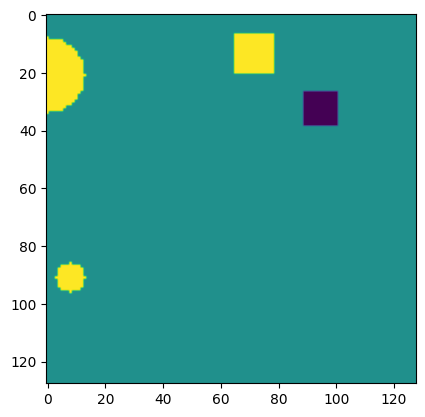

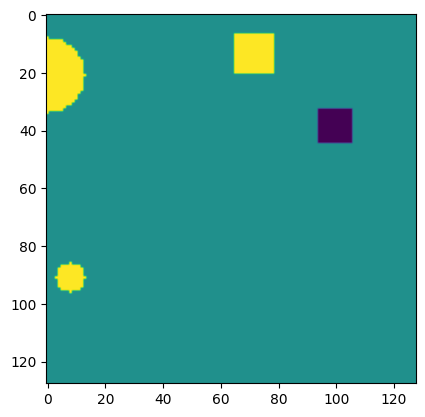

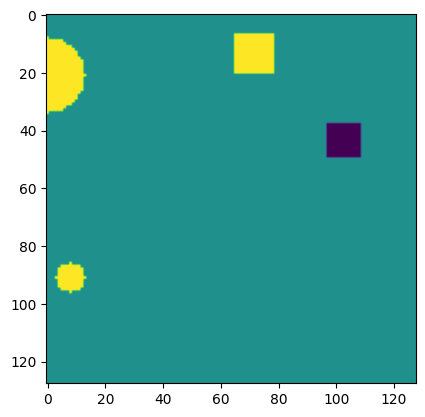

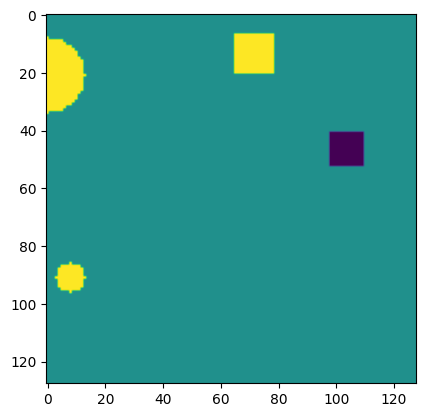

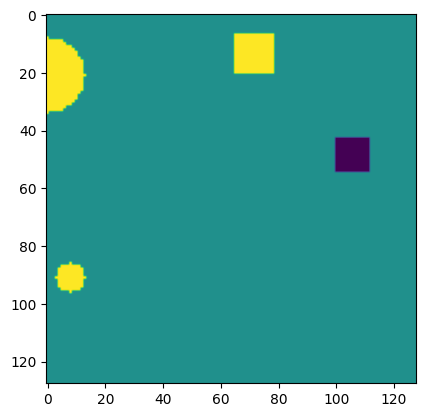

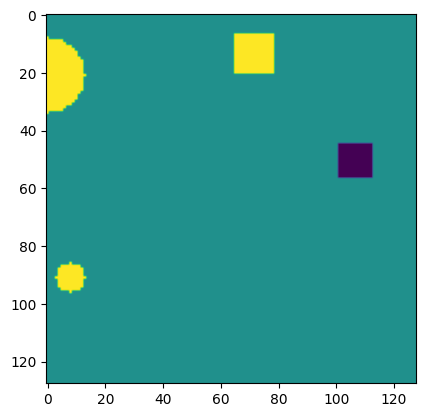

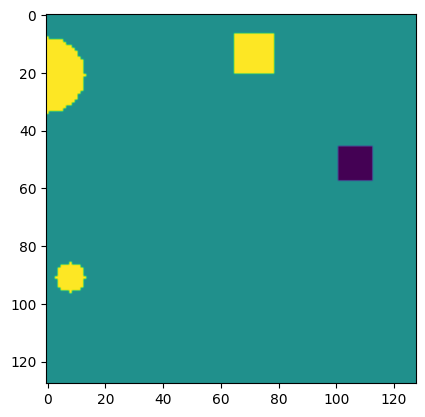

In [16]:
states, actions = env.generate_trajectory(10, max_step=scale * 2)
print(actions)
for state in states:
    plt.imshow(env.plot_enviroment(state))
    plt.show()

(104, 26) (89, 54) False


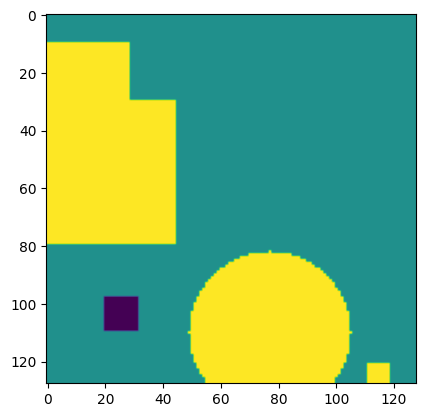

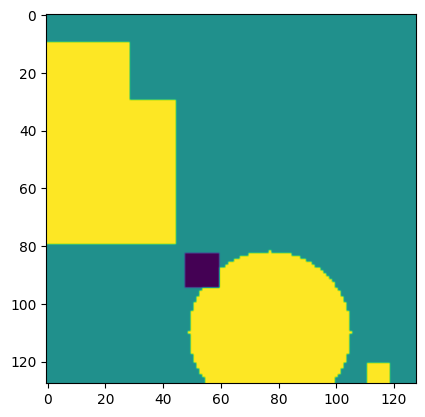

In [8]:
state1, state2, label = env.generate_collision(max_dist=scale * 8)
print(state1, state2, label)
plt.imshow(env.plot_enviroment(state1))
plt.show()
plt.imshow(env.plot_enviroment(state2))
plt.show()

### Class balance

In [12]:
import numpy as np

labels = []
for _ in range(1000):
    env, _, _ = get_random_env(scale)
    for __ in range(10):
        labels.append(env.generate_collision(max_dist=scale * 8)[-1])
np.mean(labels)

0.5277

### Dataset

In [11]:
!python ../src/generate_data.py -n 1 ../data/dev

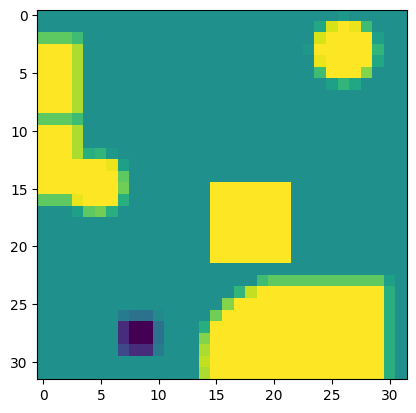

In [2]:
from dataset_image import LSBMPDataset

dataset = LSBMPDataset("../data/train")
plt.imshow(dataset[0][0])
plt.show()

tensor([-1.6710, -0.5565]) tensor([-1.6964, -0.3690])


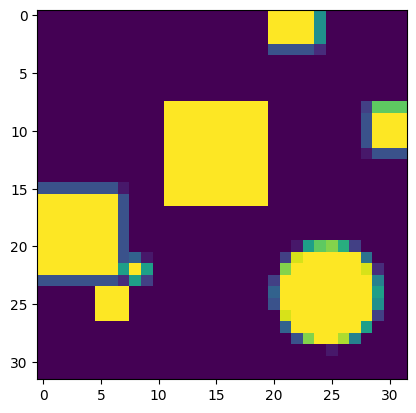

In [37]:
from dataset_collision import CollisionDataset

dataset_collision = CollisionDataset("../data/train_collision")
i = 20
print(dataset_collision[i][0], dataset_collision[i][1])
plt.imshow(dataset_collision[i][2])
plt.show()

In [38]:
dataset_collision.latents1

array([[ 0.41610361, -0.48363507],
       [ 0.49007085, -0.44253464],
       [-1.15718495,  0.51337209],
       ...,
       [ 0.8408476 , -2.67208959],
       [-0.22637555,  0.64435173],
       [ 0.49787604,  1.05320085]])

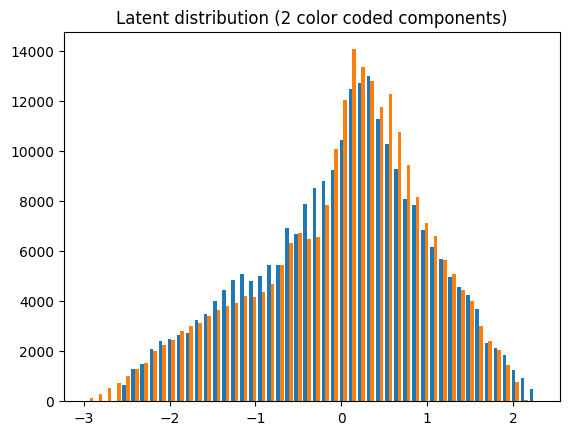

In [40]:
plt.hist(dataset_collision.latents1, bins=50)
# plt.yscale("log")
# plt.axvline(dataset.latents1[:, 0].mean())
plt.title("Latent distribution (2 color coded components)")
plt.show()

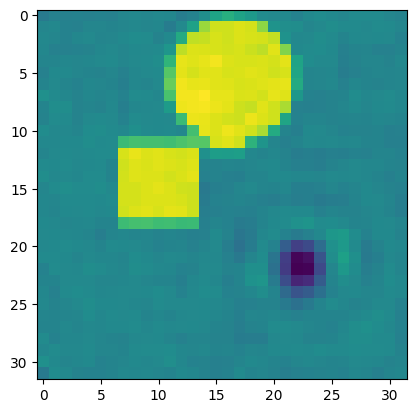

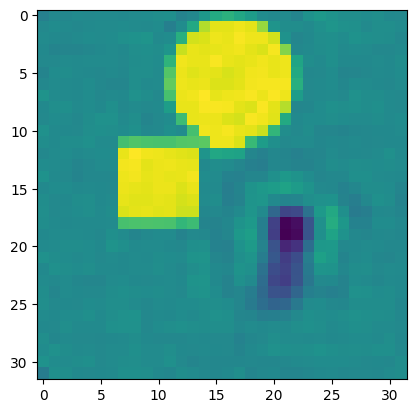

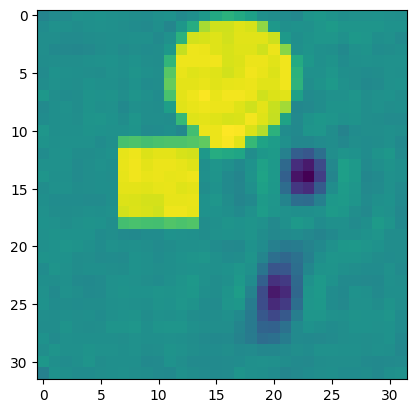

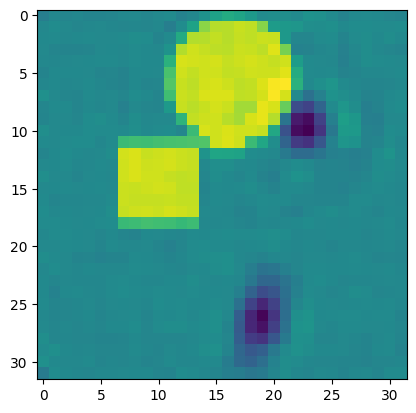

In [6]:
import torch

from model import AutoEncoder_Dynamics

enc_dyn_net = AutoEncoder_Dynamics()
enc_dyn_net.load_state_dict(torch.load("../checkpoints/dyn_model (copy 1).pth", weights_only=True))
enc_dyn_net.eval()
x_total = None
for i in range(30, 40, 3):
    x = dataset[i][0].unsqueeze(0)
    empty = dataset[i][2].unsqueeze(0)
    with torch.no_grad():
        z = enc_dyn_net.encode(x, torch.tensor([], dtype=torch.float32))[1]
        x_hat = enc_dyn_net.decode(z, empty).squeeze().cpu().numpy()
    if x_total is None:
        x_total = x_hat
    else:
        x_hat_masked = (x_hat < 0.5) * x_hat
        x_total += 0.5 - x_hat_masked
    # plt.imshow(dataset[i][0])
    # plt.show()
    plt.imshow(x_hat)
    plt.show()

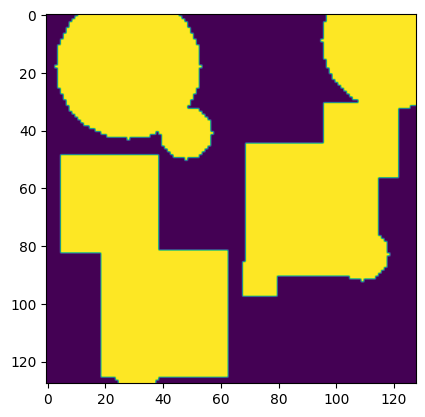

In [31]:
scale = 4
env, _, _ = get_random_env(scale)
plt.imshow(env._env)
plt.show()

In [32]:
def resize(img, scale):
    return cv2.resize(img, dsize=(img.shape[1] // scale, img.shape[0] // scale), interpolation=cv2.INTER_AREA)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
enc_dyn_net.to(device)

xs = []
lengths = []
for i in range(1024):
    states, actions = env.generate_trajectory(10, max_step=scale * 2)
    scaled_actions = []
    for action in actions:
        scaled_actions.append((action[0] / scale, action[1] / scale))
    for state in states:
        xs.append(resize(env.plot_enviroment(state), scale))
    lengths.append(len(states))
xs = torch.tensor(np.stack(xs), dtype=torch.float32).to(device)
with torch.no_grad():
    zs = enc_dyn_net.encode(xs, torch.tensor([], dtype=torch.float32).to(device))[1].cpu().numpy()
# print(zs)
    # x_hat = enc_dyn_net.decode(z, empty).squeeze().cpu().numpy()

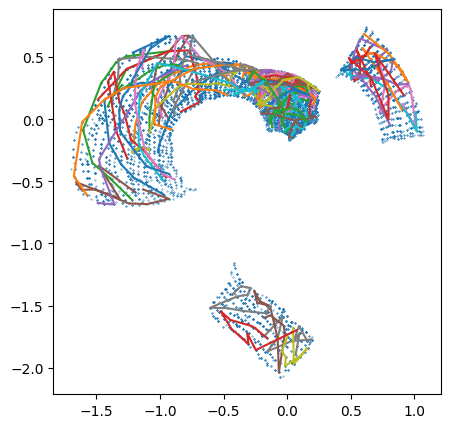

In [33]:
plt.figure(figsize=(5, 5))
plt.scatter(zs[:, 0], zs[:, 1], s=0.1)
i = 0
for l in lengths[:64]:
    plt.plot(zs[i:i + l, 0], zs[i:i + l, 1])
    i += l
plt.show()

In [6]:
import pandas as pd

In [8]:
df = pd.read_csv("geometric_data.csv")
df

,2.0,4.0,5.0,5.0.1,6.0,6.0.1,7.0,7.0.1,8.0,8.0.1,...,50.0.94,50.0.95,49.0.53,48.0.77,47.0.53,46.0.44,4.0.14,2.0.5,-0.1331538773661444,-0.038732802222191505
0,2.0,4.0,5.0,5.0,6.0,6.0,7.0,7.0,8.0,8.0,...,50.0,50.0,49.0,48.0,47.0,46.0,4.0,2.0,0.091638,-0.055993
1,2.0,4.0,5.0,5.0,6.0,6.0,38.0,50.0,62.0,63.0,...,40.0,50.0,49.0,48.0,47.0,46.0,45.0,44.0,-0.013827,-0.023591
2,2.0,4.0,5.0,5.0,6.0,6.0,38.0,50.0,62.0,63.0,...,40.0,50.0,49.0,48.0,47.0,46.0,45.0,44.0,-0.023065,-0.077096
3,2.0,4.0,5.0,5.0,6.0,6.0,38.0,50.0,62.0,63.0,...,40.0,50.0,49.0,48.0,47.0,46.0,45.0,44.0,0.134355,-0.062330
4,2.0,4.0,5.0,5.0,6.0,6.0,38.0,50.0,62.0,63.0,...,40.0,50.0,49.0,48.0,47.0,46.0,45.0,44.0,0.147079,-0.077733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,2.0,4.0,5.0,47.0,48.0,51.0,60.0,61.0,62.0,63.0,...,7.0,7.0,6.0,6.0,5.0,5.0,4.0,2.0,-0.131208,-0.148243
4995,2.0,4.0,5.0,47.0,48.0,51.0,60.0,61.0,62.0,63.0,...,7.0,7.0,6.0,6.0,5.0,5.0,4.0,2.0,0.046536,0.023246
4996,2.0,4.0,5.0,47.0,48.0,51.0,60.0,61.0,62.0,63.0,...,7.0,7.0,6.0,6.0,5.0,5.0,4.0,2.0,0.130284,-0.087056
4997,2.0,4.0,5.0,5.0,6.0,6.0,7.0,7.0,8.0,8.0,...,7.0,7.0,6.0,6.0,5.0,5.0,4.0,2.0,-0.084051,-0.094022


In [9]:
32 * 32 * 3 + 2

3074